In [204]:
# spot check machine learning algorithms on the german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import plot_roc_curve, classification_report
from sklearn.svm import SVC

In [205]:
# load the dataset 
df = pd.read_csv("credit-g.csv") 
 

In [206]:
#check datasets
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13   other_payment_plans    1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

Dataset is comprised of numeric and categorical data types, hence would require to encode the categorical variables.

In [208]:
# check for imbalance in dataset

df['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

The dataset is imbalanced and hence would influence the choice of data preprocessing and algorithm for model creation.

In [209]:
#Check summary statistics
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


There is a wide margin in the spread for some numeric variables such as age, duration and with the credit amount variable showing the most spread. Hence a need to normalise the dataset. In addition, the mean for the above variables is greater than the median which suggest a positive skew. Also, the count shows no missing data.

AxesSubplot(0.125,0.125;0.62x0.755)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B48FC6E588>


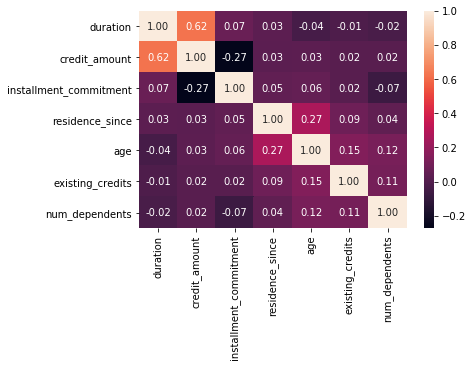

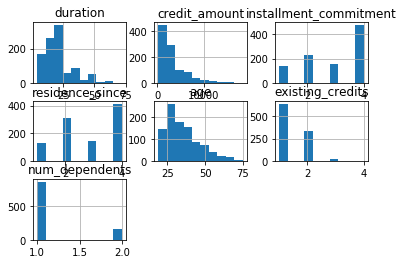

In [210]:
def EDA(data):
                
    print(sns.heatmap(data.corr(), annot=True, fmt='.2f'))
    print(data.hist())
EDA(df)

The histogram shows different distributions, some with Gaussian-like distributions, others with seemingly exponential or 
discrete distributions. Hence the dataset and distribution would be scaled in order to be useful for the modeling algorithms. The three continuous variables, duration, age and credit_amount are positively skewed to the right as their mean is greater than the median values. The heatmap shows a strong correlation is between age, credit_amount and duration variables.

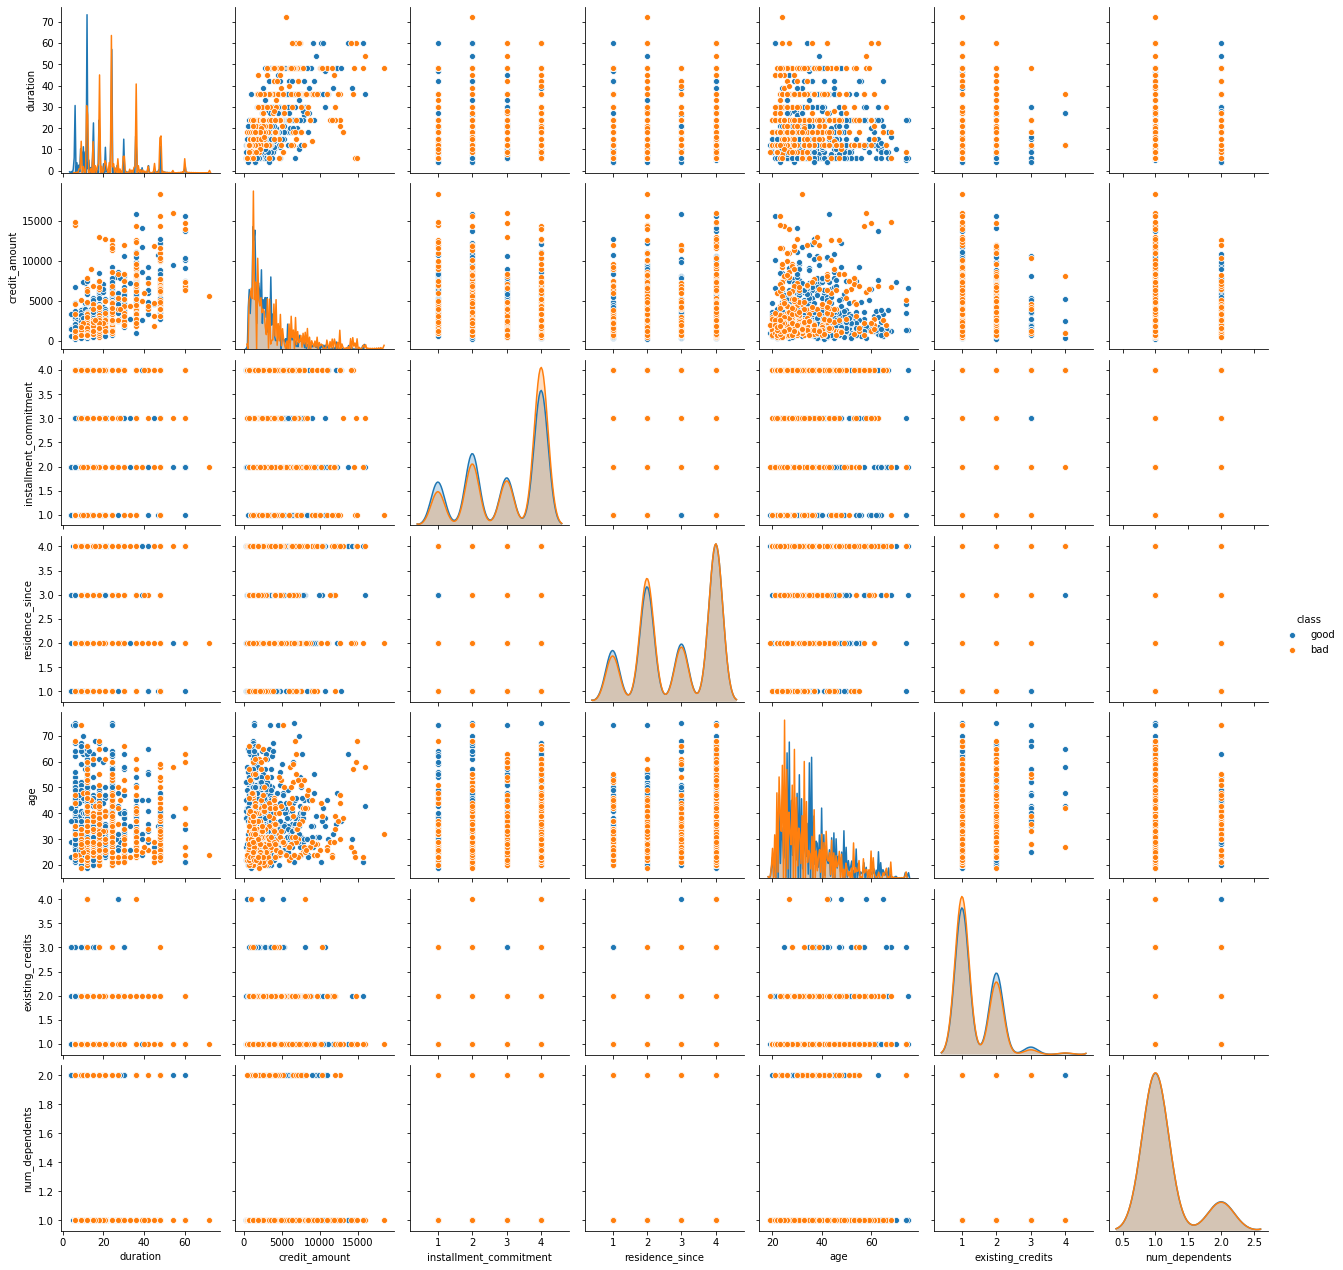

In [211]:
# Explore pairplots
sns.pairplot(df, hue = 'class', diag_kws={'bw': 0.2})

The scatter plot shows a some linear and tree-based distribution whch would inform the choice of the algorithm. Also, there are multiple peaks in the distribution of the histogram for some variables, this phenomena would needs further investigation.  

In [212]:
# Data preprocessing
def process_dataset(data):
    # split into inputs and outputs
    last_ix = len(dataframe.columns) - 1
    X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
    # select categorical and numerical features
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns 
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X.values, y, cat_ix, num_ix

In [213]:
# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # RF
    models.append(RandomForestClassifier())
    names.append('RFC')
    # GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

In [214]:
# calculate f1-measure as metric given dataset imbalance
def f1_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [215]:
# evaluate a model using stratified cross validation and the function cross_val_score to minimise overfitting.
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f1_measure)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

Stratified cross validation is suitable for this dataset becuase the values in the response variable are imbalanced. Stratified sampling divides element in a population into small groups based on similarity in such a way that the elements within the group are homogenous and heterogenous among other sub groups formed. This will minimise overfitting in the model. We will use the function cross_val_score. cross_val_score uses stratified kfold by default.

In [216]:
# process dataset
X, y, cat_ix, num_ix = process_dataset(df)
# define models
models, names = get_models()
results = list()

>LR 0.836 (0.026)
>LDA 0.835 (0.023)
>NB 0.721 (0.140)
>RFC 0.846 (0.025)
>GPC 0.837 (0.011)
>SVM 0.843 (0.019)


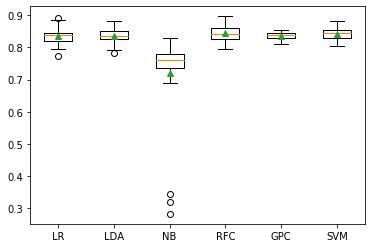

In [217]:
# evaluate each model with the f1-score metric
for i in range(len(models)):
   # wrap the model in a pipeline
    pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The best performing model is the Random Forest classifier (RFC) going by the f-1 score values above. And is best candidate model for promoting to production.

In [242]:
# prediction with RFC

model = RandomForestClassifier(n_estimators=4000, random_state=42)

In [243]:
pipeline = Pipeline(steps=[('t',ct),('m',model)])

In [244]:
pipeline.fit(X,y)

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c', OneHotEncoder(),
                                                  Int64Index([0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19], dtype='int64')),
                                                 ('n', MinMaxScaler(),
                                                  Int64Index([1, 4, 7, 10, 12, 15, 17], dtype='int64'))])),
                ('m',
                 RandomForestClassifier(n_estimators=4000, random_state=42))])

In [245]:
# predict with a known customer example with class 0.
data = ['0<=X<200', 30, 'critical/other existing credit', 'new car', 5234, '<100', 'unemployed', 4, 'male mar/wid', 'none', 2, 'car', 28,
'none', 'own', 2, 'high qualif/self emp/mgmt', 1, 'none', 'yes']

In [246]:
y_pred = pipeline.predict([data])
# get the label
label = y_pred[0]
#summarize
print('>predicted=%d (expected 0)' % (label))

>predicted=0 (expected 0)


#### Saving ML prediction to csv file

In [241]:
pred_file = pd.DataFrame(y_pred, columns=['y_pred']).to_csv('data.csv')